In [1]:
#Libraries
import pathlib
import random
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks

In [2]:
import pandas as pd

# load csv
df = pd.read_csv("/content/english_to_malayalam_500k.csv")

# write to required files
df["ml"].to_csv("train.ml", index=False, header=False)
df["en"].to_csv("train.en", index=False, header=False)


In [5]:
eng_file = '/content/train.en'
malayalam_file = '/content/train.ml'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
with open(eng_file, 'r') as file:
    english_sentences = file.readlines()
with open(malayalam_file, 'r') as file:
    malayalam_sentences = file.readlines()


english_sentences = [sentence.rstrip('\n').lower() for sentence in english_sentences]
malayalam_sentences = [sentence.rstrip('\n') for sentence in malayalam_sentences]

In [8]:
malayalam_vocabulary = [
    ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
    '0','1','2','3','4','5','6','7','8','9', ':', '<', '=', '>', '?',
    "അ","ആ","ഇ","ഈ","ഉ","ഊ","ഋ","എ","ഏ","ഐ","ഒ","ഓ","ഔ",
    "ക","ഖ","ഗ","ഘ","ങ",
    "ച","ഛ","ജ","ഝ","ഞ",
    "ട","ഠ","ഡ","ഢ","ണ",
    "ത","ഥ","ദ","ധ","ന",
    "പ","ഫ","ബ","ഭ","മ",
    "യ","ര","ല","വ",
    "ശ","ഷ","സ","ഹ",
    "ാ","ി","ീ","ു","ൂ","ൃ","െ","േ","ൈ","ൊ","ോ","ൌ",
    "ം","ഃ","്",
    "൦","൧","൨","൩","൪","൫","൬","൭","൮","൯"
]

english_vocabulary = [
    ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
    '0','1','2','3','4','5','6','7','8','9',
    ':', '<', '=', '>', '?', '@',
    '[', '\\', ']', '^', '_', '`',
    'a','b','c','d','e','f','g','h','i','j','k','l',
    'm','n','o','p','q','r','s','t','u','v','w','x','y','z',
    '{', '|', '}', '~'
]


In [9]:
MAX_LEN = 40

malayalam_sentences = open("train.ml", encoding="utf-8").read().splitlines()
english_sentences   = open("train.en", encoding="utf-8").read().splitlines()

valid_sentence_indicies = [
    i for i in range(len(english_sentences))
    if len(english_sentences[i].split()) <= MAX_LEN
    and len(malayalam_sentences[i].split()) <= MAX_LEN
]


In [73]:
TOTAL_SENTENCES = 50000  # lets take 500000 valid sentences to train the model
x = [malayalam_sentences[i] for i in valid_sentence_indicies]
y = [english_sentences[i] for i in valid_sentence_indicies]


In [74]:
import pandas as pd

dataset = pd.DataFrame({
    "Malayalam": x,
    "English": y
})

dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493843 entries, 0 to 493842
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Malayalam  493843 non-null  object
 1   English    493843 non-null  object
dtypes: object(2)
memory usage: 7.5+ MB


In [75]:
dataset.sample(5)

,Malayalam,English
315109,തമിഴില്‍ തിരക്കഥയെഴുതി.,The script is Tamil.
171532,ഒരു ഡോക്ടര്‍ !,A doctor!
147454,ആ തിരയിളക്കേണ്ടത്‌ നമ്മളാണ്‌.,This is what we are seeking.
275904,"""ഉദാഹരണത്തിന്, ജോൺ ഉറങ്ങുകയായിരുന്നു, ജോൺ എല്ല...","""For example, John was sleeping, John sleeps e..."
473694,പക്ഷേ ശരിക്കും ഉമ്മ വച്ചിട്ടൂല്ല്യ'.,"""""""But I really dont mind it."""""""""""""""


In [76]:
import os

save_dir = "/content/drive/MyDrive/Project_3"
os.makedirs(save_dir, exist_ok=True)
dataset.to_csv('/content/drive/MyDrive/Project_3/data.csv' , index = False )

In [77]:
dataset = pd.read_csv('/content/english_to_malayalam_500k.csv')
dataset.head()


,en,ml
0,The plot of the movie revolves around the life...,"ക്യാന്‍സറിനോട് പോരാടുന്ന കിസി, മാനി എന്നിവരുടെ..."
1,The same as on the stone.,കല്ലിൽ കണ്ട അതേ രൂപം.
2,"Oommen Chandy, Mullappally Ramachandran, Rames...",മാണി നയിക്കുന്ന കേരള യാത്രയിലുടനീളം ഉമ്മന്‍ചാണ...
3,Many were arrested and jailed.,നിരപരാധികളായ പലരേയും കസ്റ്റഡിയിലെടുത്ത് പീഢിപ്...
4,what has happened?,എന്താണു സംഭവം?


In [83]:
text_pairs = []

for i in range(dataset.shape[0]):
    eng = str(dataset["en"][i])
    ml  = "[start] " + str(dataset["ml"][i]) + " [end]"
    text_pairs.append((ml, eng))
text_pairs = text_pairs[:50000]


In [84]:
len(text_pairs)


50000

In [85]:
train_sample_size = len(text_pairs) - int(0.1*len(text_pairs))
train_pairs = text_pairs[:train_sample_size]
test_pairs = text_pairs[train_sample_size:]

In [86]:
print("Total pairs :", len(text_pairs))
print("Train pairs :", len(train_pairs))
print("Test pairs :", len(test_pairs))

Total pairs : 50000
Train pairs : 45000
Test pairs : 5000


In [87]:
strip_chars = string.punctuation + "|"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
strip_chars = strip_chars.replace('""', "")

vocab_size = 35000
sequence_length = 30
batch_size = 64

In [88]:

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [89]:
eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

ml_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)


In [90]:
train_eng_texts = [pair[1] for pair in train_pairs]
train_ml_texts  = [pair[0] for pair in train_pairs]

eng_vectorization.adapt(train_eng_texts)
ml_vectorization.adapt(train_ml_texts)


In [91]:
import json

# Get the vocabulary
eng_vocab = eng_vectorization.get_vocabulary()
ml_vocab  = ml_vectorization.get_vocabulary()

# Save the vocabulary
with open('/content/eng_vocab.json', 'w') as f:
    json.dump(eng_vocab, f)
with open('/content/ml_vocab.json', 'w') as f:
    json.dump(ml_vocab, f)


In [92]:
import json

vocab_size = 35000
sequence_length = 30
batch_size = 64

# Load the vocabulary
with open('/content/eng_vocab.json', 'r') as f:
    eng_vocab = json.load(f)
with open('/content/ml_vocab.json', 'r') as f:
    ml_vocab = json.load(f)

# Create TextVectorization layers with the loaded vocabulary
eng_vectorization = TextVectorization(
    vocabulary=eng_vocab,
    output_mode="int",
    output_sequence_length=sequence_length
)

ml_vectorization = TextVectorization(
    vocabulary=ml_vocab,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization
)


In [93]:
def format_dataset(ml, eng):
    ml  = ml_vectorization(ml)
    eng = eng_vectorization(eng)
    return (
        {
            "encoder_inputs": ml,
            "decoder_inputs": eng[:, :-1],
        },
        eng[:, 1:],
    )


In [94]:
def make_dataset(pairs):
    ml_texts, eng_texts = zip(*pairs)
    ml_texts  = list(ml_texts)
    eng_texts = list(eng_texts)

    dataset = tf.data.Dataset.from_tensor_slices((ml_texts, eng_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


In [95]:
train_ds = make_dataset(train_pairs)
test_ds = make_dataset(test_pairs)

In [96]:
for inputs, targets in train_ds.take(2):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 31)
inputs["decoder_inputs"].shape: (64, 29)
targets.shape: (64, 29)
inputs["encoder_inputs"].shape: (64, 31)
inputs["decoder_inputs"].shape: (64, 29)
targets.shape: (64, 29)


In [97]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [98]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
         return keras.ops.not_equal(inputs, 0)

In [99]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
      causal_mask = self.get_causal_attention_mask(inputs)

      # Self-attention (decoder)
      attention_output_1 = self.attention_1(
          query=inputs,
          value=inputs,
          key=inputs,
          attention_mask=causal_mask,
      )
      out_1 = self.layernorm_1(inputs + attention_output_1)

      # Cross-attention (decoder → encoder)
      attention_output_2 = self.attention_2(
          query=out_1,
          value=encoder_outputs,
          key=encoder_outputs,
          # ❌ do NOT pass causal or mixed mask here
      )
      out_2 = self.layernorm_2(out_1 + attention_output_2)

      proj_output = self.dense_proj(out_2)
      return self.layernorm_3(out_2 + proj_output)


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [100]:
embed_dim = 256
latent_dim = 512
num_heads = 4


encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)
i

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:1474: UserWarning: Layer 'transformer_encoder_2' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''cannot access local variable 'padding_mask' where it is not associated with a value''
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'transformer_encoder_2', however the layer does not have a `build()` method impleme

499999

In [101]:
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

In [102]:
decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'functional_11' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [103]:
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  8,967,680 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, None)      │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  1,315,840 │ positional_embed… │
│ (TransformerEncode… │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_11       │ (None, None,      │ 20,330,936 │ decoder_inputs[0… │
│ (Functional)        │ 35000)            │            │ transformer_enco… │
│                     │                   │            │ not_equal_4[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,614,456 (116.78 MB)

 Trainable params: 30,614,456 (116.78 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    return {"d_model": self.d_model.numpy(), "warmup_steps": self.warmup_steps}

In [105]:
learning_rate = CustomSchedule(latent_dim)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)


Text(0.5, 0, 'Train Step')

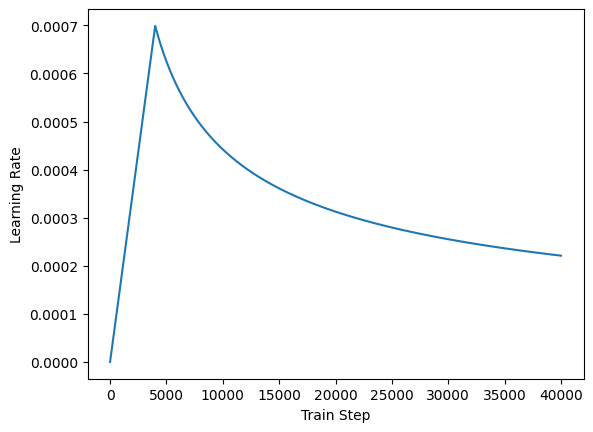

In [106]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [107]:
import os

drive_root = "/content/drive/MyDrive/Malayalam_transformer"

# Create directories if not exist
os.makedirs(drive_root, exist_ok=True)

checkpoint_filepath = os.path.join(drive_root, "checkpoint_Malayalam_transformer.keras")
csv_log_filepath = os.path.join(drive_root, "training_log_Malayalam_transformer.csv")
backup_dir = os.path.join(drive_root, "backup_Malayalam_transformer")
os.makedirs(backup_dir, exist_ok=True)


In [108]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

csv_logger = callbacks.CSVLogger(csv_log_filepath, append=True)

backup_callback = callbacks.BackupAndRestore(
    backup_dir=backup_dir,
    delete_checkpoint=False
)

all_callbacks = [early_stopping, model_checkpoint_callback, csv_logger, backup_callback]


In [109]:

epochs = 28
transformer.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [110]:
history = transformer.fit(train_ds,
                epochs=epochs,
                validation_data=test_ds ,
                callbacks=[
                      early_stopping ,
                      model_checkpoint_callback ,
                      csv_logger ,
                      backup_callback ] )

Epoch 1/28
704/704 ━━━━━━━━━━━━━━━━━━━━ 96s 117ms/step - accuracy: 0.4117 - loss: 9.4507 - val_accuracy: 0.7103 - val_loss: 6.7750
Epoch 2/28
704/704 ━━━━━━━━━━━━━━━━━━━━ 79s 112ms/step - accuracy: 0.7178 - loss: 6.5756 - val_accuracy: 0.7281 - val_loss: 6.1511
Epoch 3/28
704/704 ━━━━━━━━━━━━━━━━━━━━ 75s 107ms/step - accuracy: 0.7321 - loss: 5.9894 - val_accuracy: 0.7348 - val_loss: 5.8604
Epoch 4/28
704/704 ━━━━━━━━━━━━━━━━━━━━ 72s 102ms/step - accuracy: 0.7413 - loss: 5.6707 - val_accuracy: 0.7398 - val_loss: 5.7060
Epoch 5/28
704/704 ━━━━━━━━━━━━━━━━━━━━ 72s 102ms/step - accuracy: 0.7495 - loss: 5.3925 - val_accuracy: 0.7440 - val_loss: 5.6127
Epoch 6/28
704/704 ━━━━━━━━━━━━━━━━━━━━ 68s 97ms/step - accuracy: 0.7548 - loss: 5.1517 - val_accuracy: 0.7362 - val_loss: 5.6057
Epoch 7/28
704/704 ━━━━━━━━━━━━━━━━━━━━ 71s 101ms/step - accuracy: 0.7581 - loss: 4.8876 - val_accuracy: 0.7179 - val_loss: 5.5509
Epoch 8/28
704/704 ━━━━━━━━━━━━━━━━━━━━ 71s 101ms/step - accuracy: 0.7678 - loss: 4.

In [111]:
transformer.save('/content/V1-50k-106M.keras')


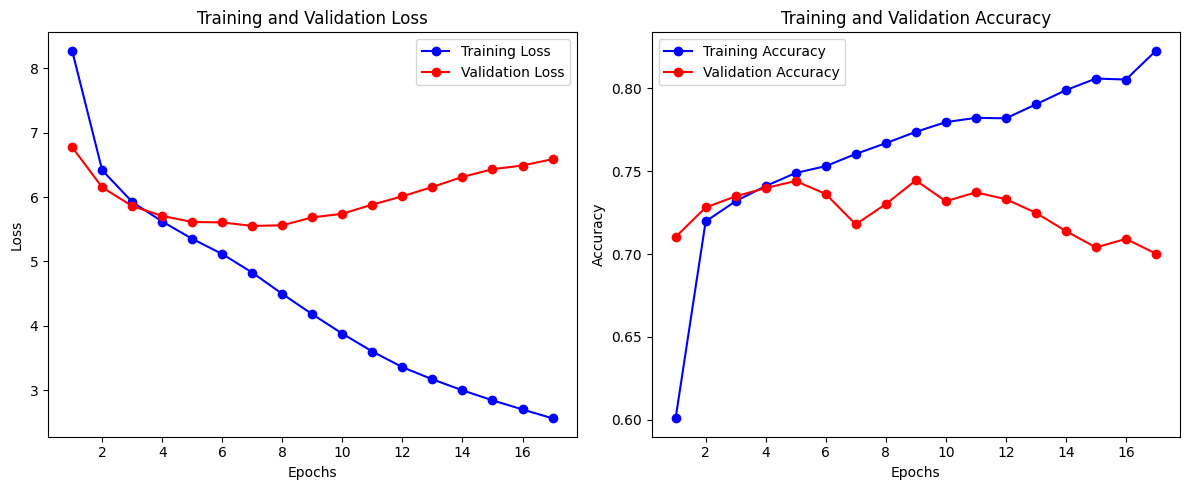

In [112]:
import os
def plot_loss_and_accuracy(history, save_dir=None, filename=None):
    # Extract the loss and accuracy values from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Get the number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    plt.show()
plot_loss_and_accuracy(history ,"/content/drive/MyDrive/NMT-Project", "V1-50k-106M_trainloss.png" )

In [113]:
en_vocab = eng_vectorization.get_vocabulary()
en_index_lookup = dict(zip(range(len(en_vocab)), en_vocab))


In [114]:
for batch in test_ds.take(1):
    inputs, targets = batch
    predictions = transformer(inputs, training=False)
    break

predicted_ids = tf.argmax(predictions, axis=-1)

ml_vocab = ml_vectorization.get_vocabulary()
en_vocab = eng_vectorization.get_vocabulary()

def decode_tokens(token_ids, vocab):
    return " ".join([vocab[t] for t in token_ids if t != 0])


### Testing on Random Train Samples

In [125]:
for idx in range(10,20):
  encoder_input = inputs["encoder_inputs"][idx].numpy()
  ground_truth  = targets[idx].numpy()
  model_output  = predicted_ids[idx].numpy()

  print("Malayalam (Input):")
  print(decode_tokens(encoder_input, ml_vocab))

  print("\nEnglish (Ground Truth):")
  print(decode_tokens(ground_truth, en_vocab))

  print("\nEnglish (Model Output):")
  print(decode_tokens(model_output, en_vocab))


Malayalam (Input):
[start] തെരഞ്ഞെടുപ്പ് ചൂട് [UNK] [end]

English (Ground Truth):
election heat is on

English (Model Output):
election is is going
Malayalam (Input):
[start] [UNK] തണുത്തു [UNK] [end]

English (Ground Truth):
[UNK]

English (Model Output):
the
Malayalam (Input):
[start] [UNK] ഫോട്ടോകള്‍ [UNK] [end]

English (Ground Truth):
viral photos

English (Model Output):
media on
Malayalam (Input):
[start] [UNK] ഉത്തരം നൽകുന്നു “ദുഷ്ടന്മാരുടെ സൌഖ്യം [UNK] എനിക്കു [UNK] അസൂയ തോന്നി ” [end]

English (Ground Truth):
as he proceeded to come into the temple sanctuary of god he came to realize that on [UNK] ground is where jehovah had placed them

English (Model Output):
the the was to the to the answer and was the and was to be that is the and not he a the and
Malayalam (Input):
[start] എന്നാൽ അവിടെ നിന്നും ഒരു നടപടി [UNK] [end]

English (Ground Truth):
no action is forthcoming

English (Model Output):
no action was taken
Malayalam (Input):
[start] നേരത്തേ കോണ്‍ഗ്രസ് അധ്യക്ഷന്‍ രാഹുല

In [126]:
# ========= PRINT MODEL OUTPUT (SAFE & CORRECT) =========

import tensorflow as tf

# Take one batch from test dataset
for batch in test_ds.take(1):
    inputs, targets = batch
    predictions = transformer(inputs, training=False)
    break

# Convert predictions to token IDs
predicted_ids = tf.argmax(predictions, axis=-1)

# Get vocabularies
ml_vocab = ml_vectorization.get_vocabulary()
en_vocab = eng_vectorization.get_vocabulary()

def decode_tokens(token_ids, vocab):
    return " ".join([vocab[t] for t in token_ids if t != 0])

# Select first sample in batch
idx = 0
encoder_input = inputs["encoder_inputs"][idx].numpy()
ground_truth  = targets[idx].numpy()
model_output  = predicted_ids[idx].numpy()

print("Malayalam (Input):")
print(decode_tokens(encoder_input, ml_vocab))

print("\nEnglish (Ground Truth):")
print(decode_tokens(ground_truth, en_vocab))

print("\nEnglish (Model Output):")
print(decode_tokens(model_output, en_vocab))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'functional_11' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Malayalam (Input):
[start] നിങ്ങള്‍ ആരെയാണ് ഭയപ്പെടുന്നത് മിസ്റ്റര്‍ [end]

English (Ground Truth):
do you fear

English (Model Output):
are you want you


In [ ]:
!pip install --quiet evaluate sacrebleu bert_score rouge_score


In [ ]:

import sacrebleu
import evaluate

# Assume text_pairs = [(english_sentence, hindi_reference), ...]
test_pairs = text_pairs[:200]

refs = [[ref.replace("[start] ", "").replace(" [end]", "") for _, ref in test_pairs]]
hyps = [decode_sequence(eng) for eng, _ in test_pairs]

# Store scores
scores = {}

# SacreBLEU
bleu = sacrebleu.corpus_bleu(hyps, refs)
scores["SacreBLEU"] = bleu.score

# METEOR
meteor = evaluate.load("meteor")
meteor_score = meteor.compute(predictions=hyps, references=refs[0])
scores["METEOR"] = meteor_score["meteor"]

# TER
ter = evaluate.load("ter")
ter_score = ter.compute(predictions=hyps, references=refs[0])
scores["TER"] = ter_score["score"]  # lower is better

# chrF++
chrf = evaluate.load("chrf")
chrf_score = chrf.compute(predictions=hyps, references=refs[0])
scores["chrF++"] = chrf_score["score"]

# BERTScore (semantic similarity)
try:
    bertscore = evaluate.load("bertscore")
    bertscore_score = bertscore.compute(predictions=hyps, references=refs[0], lang="en")
    scores["BERTScore (F1)"] = sum(bertscore_score["f1"]) / len(bertscore_score["f1"]) * 100
except Exception as e:
    print("BERTScore could not be computed:", e)

# ROUGE-L
rouge = evaluate.load("rouge")
rouge_score = rouge.compute(predictions=hyps, references=refs[0])
scores["ROUGE-L"] = rouge_score["rougeL"] * 100

# Print all scores
print("All metrics:")
for k, v in scores.items():
    print(f"{k}: {v:.4f}")

# Select top 3 scores (higher is better, TER is reversed)
sorted_scores = sorted(
    scores.items(),
    key=lambda x: x[1] if x[0] != "TER" else -x[1],
    reverse=True
)
print("\nTop 3 metrics:")
for metric, value in sorted_scores[:3]:
    print(f"{metric}: {value:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'functional_3' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


All metrics:
SacreBLEU: 3.3664
METEOR: 0.2285
TER: 125.6854
chrF++: 24.5112
BERTScore (F1): 87.3126
ROUGE-L: 0.0000

Top 3 metrics:
BERTScore (F1): 87.3126
chrF++: 24.5112
SacreBLEU: 3.3664


In [ ]:
# pick a random training pair
import random

sample = random.choice(train_pairs)

# HI → EN direction
input_sentence  = sample[0]   # Hindi (encoder input)
output_sentence = sample[1]   # English (ground truth)

# model prediction

print("========== MODEL I/O ==========")

print("\nINPUT to Encoder (Hindi):")
print(input_sentence)

print("\nEXPECTED OUTPUT (English - Ground Truth):")
print(output_sentence)




========== MODEL I/O ==========

INPUT to Encoder (Hindi):
And God,“ he said to the poor man, ”is answering your plea

EXPECTED OUTPUT (English - Ground Truth):
[start] “और भगवान्”, उन्होंने गरीब व्यक्ति से कहा, “तुम्हारी प्रार्थना सुन रहे हैं [end]
